<a href="https://colab.research.google.com/github/Alf-caput/NonVerbalAudioClassifier/blob/dev4/src/tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip

--2024-04-16 12:24:10--  https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fuld3z222j9t1oy/vs_release_16k.zip [following]
--2024-04-16 12:24:11--  https://www.dropbox.com/s/raw/fuld3z222j9t1oy/vs_release_16k.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8bcc41356cc6e947072aba696d.dl.dropboxusercontent.com/cd/0/inline/CRJ_d64L543lluWi7XJniugedXavsMNn6nrqqRWVgBirXAjO33wVEKjUzUZdn0bYiwEyv-ZFNJMdY83Uo9TTjcdKBbFzNzYRpUdinuVRT1zSTwoP_TWxeqXBz8lZAc0QUstOuvkC1r9VS0jHZOag_xr3/file# [following]
--2024-04-16 12:24:11--  https://uc8bcc41356cc6e947072aba696d.dl.dropboxusercontent.com/cd/0/inline/CRJ_d64L543lluWi7XJniugedXavsMNn6nrqqRWVgBirXAjO33wVEKjUzUZdn0bYiwEyv-ZFNJMdY83Uo

In [2]:
# import os

# zip_filename = 'vs_release_16k.zip'

# if not os.path.exists(zip_filename):
#     os.system("wget https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip")

Dentro de vs_release_16k.zip descomprimimos:  
- audio_16k  

Nos servimos del módulo zipfile para descomprimir.  

In [2]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

zip_filename = 'vs_release_16k.zip'
audio_dir = 'audio_16k/'

if not os.path.exists(audio_dir):
    with ZipFile(zip_filename, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if file.startswith(audio_dir):
                    exe.submit(zf.extract, file)

In [3]:
import tensorflow as tf

audio_dir = 'audio_16k/'
seed = 42

tf.random.set_seed(seed)

filenames = tf.io.gfile.glob(audio_dir + '*')
filenames = tf.random.shuffle(filenames, seed)

print('Total audios:', len(filenames))
print('Example:', filenames.shape)

Total audios: 21023
Example: (21023,)


In [4]:
vocal_sounds = ['cough', 'laughter', 'sigh', 'sneeze', 'sniff', 'throatclearing']
num_sounds = len(vocal_sounds)

test_file = filenames[0]
def get_label(file_path):
  label = tf.strings.split(
    input=file_path,
    sep='_')[-1]

  label = tf.strings.split(
    input=label,
    sep='.')[0]

  label = tf.where(label==vocal_sounds)
  label = tf.reshape(label, ())
  return label

get_label(test_file), test_file

(<tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'audio_16k/m3342_0_sneeze.wav'>)

In [5]:
std_len = 64000
def get_signal(file_path):
  audio_binary = tf.io.read_file(file_path)
  signal = tf.audio.decode_wav(audio_binary)[0]
  signal = signal[:std_len]
  signal = tf.pad(signal, [[0, std_len-len(signal)], [0, 0]])
  return tf.squeeze(signal, axis=-1)

get_signal(test_file), test_file

(<tf.Tensor: shape=(64000,), dtype=float32, numpy=
 array([ 3.0517578e-05,  6.1035156e-05, -9.1552734e-05, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'audio_16k/m3342_0_sneeze.wav'>)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
ds_files = tf.data.Dataset.from_tensor_slices(filenames)
ds_signals = ds_files.map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)
ds_files.element_spec, ds_signals.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 (TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)))

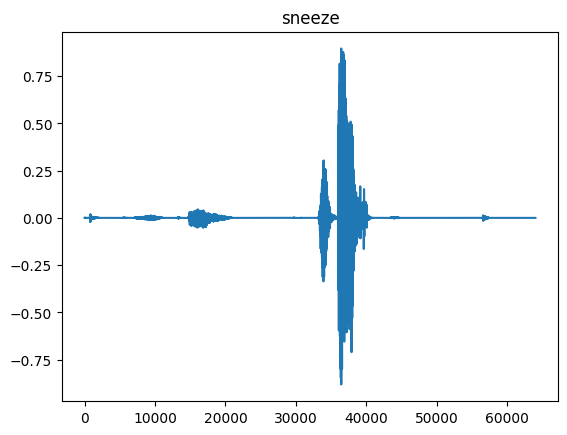

In [7]:
import matplotlib.pyplot as plt
for elem in ds_signals.take(1):
  signal, label = elem
  plt.plot(signal)
  plt.title(vocal_sounds[label])

In [8]:
def remove_shortaudio(filename):
  if get_signal(filename).shape[0] < min_len:
    tf.io.gfile.remove(filename)

initial_file_count = 21024

if len(filenames) >= initial_file_count:
  # Remove less than 0.1s audios (16kHz then 1600 frames)
  min_len = 1600
  with ThreadPoolExecutor() as exe:
    for file in filenames:
      exe.submit(remove_shortaudio, file)

  filenames = tf.io.gfile.glob(audio_dir + '*')

print('Total audios:', len(filenames))


Total audios: 21023


In [9]:
ds_files = tf.data.Dataset.from_tensor_slices(filenames)
ds_signals = ds_files.map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)

In [10]:
for elem in ds_signals.take(1):
  print(elem)

(<tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([ 3.0517578e-05,  6.1035156e-05, -9.1552734e-05, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)


In [11]:
def normalize(audio, label):
  label = tf.one_hot(label, len(vocal_sounds))
  return audio, label

ds_signals = ds_signals.map(normalize).cache()

In [12]:
for elem in ds_signals.take(1):
  print(elem)

(<tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([ 3.0517578e-05,  6.1035156e-05, -9.1552734e-05, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)>, <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0.], dtype=float32)>)


In [13]:
ds_signals.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(6,), dtype=tf.float32, name=None))

In [14]:
num_train = len(ds_signals)

RATIO = 0.2
test_size = int(RATIO * num_train)

ds_train = ds_signals.skip(test_size)
ds_test = ds_signals.take(test_size)

In [15]:
num_train = len(ds_train)

RATIO = 0.2
validation_size = int(RATIO * num_train)

ds_fit = ds_signals.skip(validation_size)
ds_val = ds_signals.take(validation_size)

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 1024
ds_fit = (
    ds_fit
    .cache()
    .shuffle(len(ds_fit))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
# Define el tamaño del subconjunto que deseas tomar
subset_size = 21080

# Toma un subconjunto de tu conjunto de datos
ds_subset = ds_signals.take(subset_size)

# Divide el subconjunto en conjuntos de entrenamiento y prueba
num_subset = len(ds_subset)
test_size_subset = int(RATIO * num_subset)

ds_train_subset = ds_subset.skip(test_size_subset)
ds_test_subset = ds_subset.take(test_size_subset)

# Realiza la división en conjunto de validación si es necesario
num_train_subset = len(ds_train_subset)
validation_size_subset = int(RATIO * num_train_subset)

ds_fit_subset = ds_train_subset.skip(validation_size_subset)
ds_val_subset = ds_train_subset.take(validation_size_subset)

# Imprime la cantidad de elementos en cada conjunto
print("Número de elementos en el conjunto de entrenamiento:", len(ds_train_subset))
print("Número de elementos en el conjunto de prueba:", len(ds_test_subset))
print("Número de elementos en el conjunto de validación:", len(ds_val_subset))



Número de elementos en el conjunto de entrenamiento: 16819
Número de elementos en el conjunto de prueba: 4204
Número de elementos en el conjunto de validación: 3363


In [ ]:
rom sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

# Define una función generadora para cargar y procesar los datos por lotes
def data_generator(dataset, batch_size):
    for signal, label in dataset.batch(batch_size):
        signal = signal.numpy()
        label = label.numpy()
        yield signal, label

# Definir parámetros
batch_size = 1000  # Tamaño del lote
num_neighbors = 5  # Número de vecinos para el clasificador KNN

# Normalizar los datos de entrenamiento
scaler = StandardScaler()

# Inicializar el clasificador KNN
knn_classifier = KNeighborsClassifier(n_neighbors=num_neighbors)

# Entrenar y actualizar el clasificador KNN por lotes
for X_batch, y_batch in data_generator(ds_train_subset, batch_size):
    X_batch_scaled = scaler.fit_transform(X_batch)
    knn_classifier.fit(X_batch_scaled, y_batch)

# Evaluar el clasificador KNN en el conjunto de prueba por lotes
y_true = []
y_pred = []

for X_batch, y_batch in data_generator(ds_test_subset, batch_size):
    X_batch_scaled = scaler.transform(X_batch)
    y_true.extend(y_batch)
    y_pred.extend(knn_classifier.predict(X_batch_scaled))

# Calcular la precisión del modelo
test_accuracy = accuracy_score(y_true, y_pred)
print("Test accuracy (KNN) using batch processing:", test_accuracy)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.0001)

epoch_wait = 5
# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=epoch_wait)

# Definimos los callbacks
callbacks = [early_stopping, reduce_lr]

In [ ]:
# # Establecer la semilla global
# seed_value = 42
# tf.random.set_seed(seed_value)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense

# # Arquitectura de la red convolucional
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(64000,)),  # Capa de entrada con 64 neuronas
#     Dense(32, activation='relu'),  # Capa oculta con 32 neuronas
#     Dense(6, activation='sigmoid')  # Capa de salida con una neurona para clasificación binaria
# ])

# # Compila el modelo
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# # Resumen de la arquitectura del modelo
# model.summary()